In [17]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow
import sys
import os
sys.path.append(os.path.abspath('..'))

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from lightgbm import LGBMClassifier
from sklearn.pipeline import make_pipeline

from src.utils import *
from src.features import *
from src.models import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
train = pd.read_parquet('../data/train.parquet')
print("Train shape:", train.shape)
test = pd.read_parquet('../data/test.parquet')
print("Test shape:", test.shape)

Train shape: (18145372, 126)
Test shape: (6897776, 125)


In [4]:
train.head()

,Id,bySelf,companyID,corporateTariffCode,frequentFlyer,nationality,isAccess3D,isVip,legs0_arrivalAt,legs0_departureAt,...,pricingInfo_isAccessTP,pricingInfo_passengerCount,profileId,ranker_id,requestDate,searchRoute,sex,taxes,totalPrice,selected
0,0,True,57323,<NA>,S7/SU/UT,36,False,False,2024-06-15T16:20:00,2024-06-15T15:40:00,...,1.0,1,2087645,98ce0dabf6964640b63079fbafd42cbe,2024-05-17 03:03:08,TLKKJA/KJATLK,True,370.0,16884.0,1
1,1,True,57323,123,S7/SU/UT,36,True,False,2024-06-15T14:50:00,2024-06-15T09:25:00,...,1.0,1,2087645,98ce0dabf6964640b63079fbafd42cbe,2024-05-17 03:03:08,TLKKJA/KJATLK,True,2240.0,51125.0,0
2,2,True,57323,<NA>,S7/SU/UT,36,False,False,2024-06-15T14:50:00,2024-06-15T09:25:00,...,1.0,1,2087645,98ce0dabf6964640b63079fbafd42cbe,2024-05-17 03:03:08,TLKKJA/KJATLK,True,2240.0,53695.0,0
3,3,True,57323,123,S7/SU/UT,36,True,False,2024-06-15T14:50:00,2024-06-15T09:25:00,...,1.0,1,2087645,98ce0dabf6964640b63079fbafd42cbe,2024-05-17 03:03:08,TLKKJA/KJATLK,True,2240.0,81880.0,0
4,4,True,57323,<NA>,S7/SU/UT,36,False,False,2024-06-15T14:50:00,2024-06-15T09:25:00,...,1.0,1,2087645,98ce0dabf6964640b63079fbafd42cbe,2024-05-17 03:03:08,TLKKJA/KJATLK,True,2240.0,86070.0,0


In [6]:
print('=== Basic EDA ===')
print(f"Total Users: {train['profileId'].nunique():,}")
print(f"Total Items: {train['Id'].nunique():,}")
print(f"Total Sessions: {train['ranker_id'].nunique():,}")
# 한번의 검색에서 사용자가 제시받는 항공편 옵션들 = 1 session
print(f"Select Rate: {train['selected'].mean():.4f}")

# 세션당 후보 수 분포
session_sizes = train.groupby('ranker_id').size()
# ranker_id(1개의 세션)의 크기 -> 몇 개의 항공편이 제시되었는지 확인
print(f"\nPer Session: {session_sizes.describe()}")

=== Basic EDA ===
Total Users: 32,922
Total Items: 18,145,372
Total Sessions: 105,539
Select Rate: 0.0058

Per Session: count    105539.000000
mean        171.930490
std         445.940118
min           1.000000
25%          19.000000
50%          50.000000
75%         154.000000
max        8236.000000
dtype: float64


In [7]:
session_stats = train.groupby('ranker_id')['selected'].agg(['sum', 'count'])
sessions_with_selection = (session_stats['sum'] > 0).sum()
print(f"실제 예약으로 이어진 세션 비율: {sessions_with_selection/len(session_stats):.4f}")

실제 예약으로 이어진 세션 비율: 1.0000


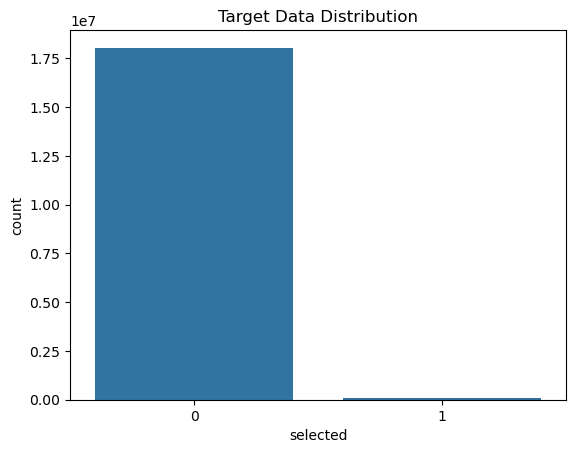

In [8]:
sns.countplot(data=train, x='selected')
plt.title('Target Data Distribution')
plt.show()

In [23]:
date = train['requestDate'].dt.date.value_counts().sort_index()
date = pd.to_datetime(date)

In [25]:
categorical_cols = train.select_dtypes(include=['object', 'category']).columns
numerical_cols = train.select_dtypes(include=[np.number]).columns

In [30]:
train['legs0_arrivalAt'].dtype

dtype('O')

In [ ]:
    for col in df.columns:
        # 1. 이미 datetime64 타입인 경우
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            datetime_cols.append(col)
        # 2. 숫자형 타입인 경우 (int, float)
        elif pd.api.types.is_numeric_dtype(df[col]):
            numerical_cols.append(col)
        # 3. 객체(object) 타입인 경우: 문자열일 가능성이 높으므로 추가 분류 필요
        elif pd.api.types.is_object_dtype(df[col]):
            # 3-1. datetime으로 변환 가능한지 시도
            # errors='coerce'를 사용하여 변환 불가능한 값은 NaT로 만듭니다.
            temp_datetime_series = pd.to_datetime(df[col], errors='coerce')

            # NaT가 아닌 값의 비율을 계산하여 datetime 여부 판단
            # NaT가 아닌 유효한 날짜가 datetime_threshold 이상이어야 datetime으로 간주
            valid_datetime_ratio = temp_datetime_series.count() / len(temp_datetime_series)

            if valid_datetime_ratio >= datetime_threshold:
                datetime_cols.append(col)
            # 3-2. datetime으로 분류되지 않으면 범주형으로 간주
            else:
                categorical_cols.append(col)
        # 4. 불리언(bool) 타입은 일반적으로 범주형 또는 이진 숫자형으로 처리될 수 있지만
        # 여기서는 편의상 numerical로 분류합니다. (0 또는 1로 변환 가능)
        # 필요에 따라 bool_cols를 따로 만들거나 categorical에 넣을 수 있습니다.
        elif pd.api.types.is_bool_dtype(df[col]):
            numerical_cols.append(col)

    return categorical_cols, datetime_cols, numerical_cols
